In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook
import imageio
import skimage

# Util function for loading meshes
from pytorch3d.io import load_obj, save_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader,
    BlendParams
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from utils import *
import json
import cv2
import numpy as np
import math
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from datetime import datetime
import os
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())
%load_ext autoreload
%autoreload 2

[03/30 03:25:36]


In [2]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# load verts and texture
img_name = '14946'
verts, faces_idx, _ = load_obj('./1_obj/AA000{}.obj'.format(img_name))

# rotate R 180 degree around viewing axis
# cos180 = math.cos(np.pi)
# sin180 = math.sin(np.pi)
# # R_z180 = torch.from_numpy(np.array([[cos180, -sin180, 0], [sin180, cos180, 0], [0, 0, 1]]))
# R_y180 = torch.from_numpy(np.array([[cos180, 0, sin180], [0, 1, 0], [-sin180, 0, cos180]]))
# verts = verts.unsqueeze(-1).double()
# R_y180 = R_y180.unsqueeze(0)
# R_y180 = R_y180.unsqueeze(0).double()
# print(verts.shape)
# print(R_y180.shape)
# verts = torch.matmul(R_y180, verts).squeeze().float()
faces = faces_idx.verts_idx

# no texture for now
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
verts_rgb[0, :, 0] = verts_rgb[0, :, 0] * 0.5
textures = Textures(verts_rgb=verts_rgb.to(device))

# create mesh bobject
person_mesh = Meshes(verts=[verts.to(device)], faces=[faces.to(device)], textures=textures)
print(person_mesh)
texture_image = person_mesh.textures.verts_rgb_packed()

In [3]:
plt.figure(figsize=(7,7))
print(texture_image.squeeze().cpu().numpy().shape)
plt.imshow(texture_image.squeeze().cpu().numpy(), cmap='gray')
plt.grid("off");
plt.axis('off');

(1669, 3)


# Renderer

### camera extrinsics

In [4]:
in_path = r'D:\CalibrationData\CameraCalibration\2020_01_01_KateyCapture_k1k2k3p1p2\FinalCamParams\cam_params.json'
with open(in_path, 'r') as f:
    j = json.load(f)
    cam_params = j['cam_params']

In [5]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cameras = []

for cam_idx, cam in enumerate(cams):
    cam_param = cam_params[str(cam_idx)]
    rvec = np.float32(cam_param['rvec'])
    T = np.float32(cam_param['tvec'])

    R, _ = cv2.Rodrigues(rvec)
    # T = -R.T.dot(T)
    R = R.T

    # R = R.dot(R_z180)
    R = torch.from_numpy(R).unsqueeze(0)
    T = torch.from_numpy(T).unsqueeze(0)
    cameras.append(OpenGLPerspectiveCameras(device=device, R=R, T=T))

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
image_size = 256
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[2000.0, 2000.0, 2000.0]])

# image
img_dir = r'Z:\2020_01_01_KateyCapture\Converted'
image_studio = cv2.imread(img_dir + '\\{}\{}{}.pgm'.format(cams[cam_idx], cams[cam_idx], img_name), cv2.IMREAD_GRAYSCALE)
print(image_studio.shape)

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
image_refs = []
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
phong_renderers = []
silhouette_renderers = []
for i in range(len(cameras)):
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras[i], raster_settings=raster_settings
        ),
        shader=HardPhongShader(
            device=device, lights=lights
        )
    )
    phong_renderers.append(phong_renderer)

    # Create a silhouette mesh renderer by composing a rasterizer and a shader. 
    # To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
    # edges. Refer to blending.py for more details. 
    silhouette_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras[i], 
            raster_settings=raster_settings
        ),
        shader=SoftSilhouetteShader(blend_params=blend_params)
    )
    silhouette_renderers.append(silhouette_renderer)

    # silhouette images
    image_ref = cv2.imread('./2b_input/{}18333.jpg'.format(cams[i]), cv2.IMREAD_GRAYSCALE)
    scale = image_size / image_ref.shape[0]
    width = int(image_ref.shape[1] * scale)
    height = int(image_ref.shape[0] * scale)
    dim = (width, height)
    image_ref = cv2.resize(image_ref, dim)
    cy = image_ref.shape[1] / 2
    image_ref = image_ref[:, int(cy-image_size/2):int(cy+image_size/2)]
    image_ref = cv2.flip(image_ref, -1) / 255.0
    image_ref = torch.from_numpy(image_ref).cuda()
    image_refs.append(image_ref)

# v2
# image_ref = silhouette_renderer(meshes_world=person_mesh)
# image_ref = image_ref.squeeze()[..., 3]

(2160, 4000)


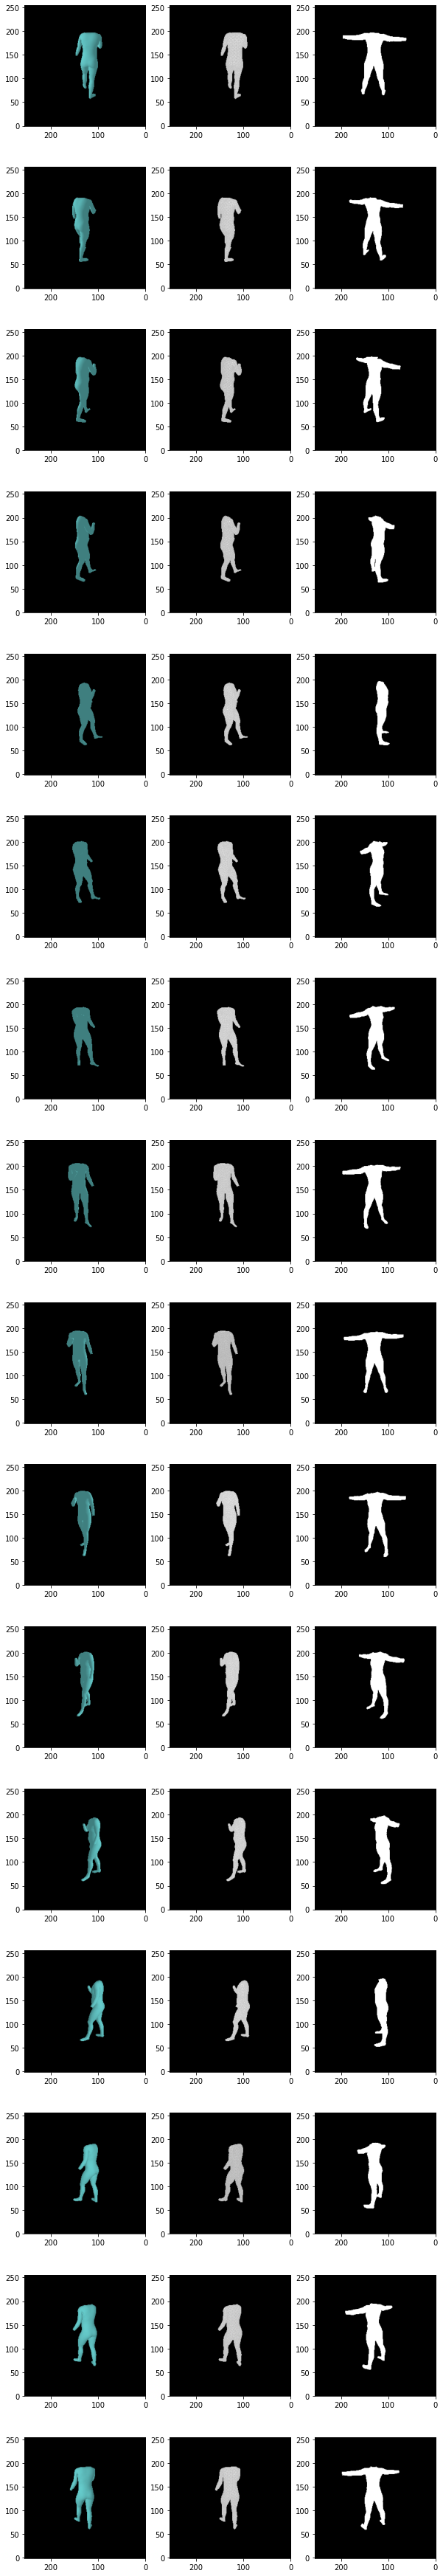

In [6]:
fig, ax = plt.subplots(len(cameras), 3, figsize=(10, len(cameras)*4))
ax = ax.ravel()

for i in range(len(cameras)):
    rendered_mesh = phong_renderers[i](meshes_world=person_mesh)
    silhouete = silhouette_renderers[i](meshes_world=person_mesh)

    n = 3*i
    ax[n].imshow(rendered_mesh.cpu().numpy().squeeze())
    ax[n].invert_yaxis()
    ax[n].invert_xaxis()

    silhouette_alpha = silhouete.cpu().numpy().squeeze()[...,3 ]
    ax[n+1].imshow(silhouette_alpha, cmap='gray')
    ax[n+1].invert_yaxis()
    ax[n+1].invert_xaxis()

    image_ref_alpha = image_refs[i].cpu().numpy().squeeze()
    ax[n+2].imshow(image_ref_alpha, cmap='gray')
    ax[n+2].invert_yaxis()
    ax[n+2].invert_xaxis()



<!-- # Model -->

# Optimizations

In [7]:
class Model(nn.Module):
    def __init__(self, meshes, phong_renderers, silhouette_renderers, image_refs, w_silhoutte, w_normal, w_laplacian):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.silhouette_renderers = silhouette_renderers
        self.phong_renderers = phong_renderers
        self.image_refs = image_refs
        #self.deform_verts = torch.full(self.meshes.verts_packed().shape, 0.0, device=meshes.device, requires_grad=True)
        self.deform_verts = nn.Parameter(
            torch.from_numpy(np.zeros(self.meshes.verts_packed().shape, dtype=np.float32)).to(meshes.device))
        self.w_silhoutte = w_silhoutte
        self.w_normal = w_normal
        self.w_laplacian = w_laplacian
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_path):
        deformed_mesh = self.meshes.offset_verts(self.deform_verts)
        
        verts = deformed_mesh.verts_packed()
        faces = deformed_mesh.faces_packed()
        vnormals = deformed_mesh.verts_normals_list()[0]
        fnormals = deformed_mesh.faces_normals_list()[0]
        
        assert(faces.shape[0] == fnormals.shape[0])
        assert(vnormals.shape[0] == verts.shape[0])
        
        with open(out_path, 'w+') as f:
            f.write('# OBJ file created by Hyojoon Park.\n')
            f.write('###########################\n')
            f.write('# Vertices:       {}\n'.format(verts.shape[0]))
            f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
            f.write('# Faces:          {}\n'.format(faces.shape[0]))
            f.write('###########################\n')

            for i in range(verts.shape[0]):
                f.write('vn {:.4f} {:.4f} {:.4f}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                f.write('v {:.4f} {:.4f} {:.4f}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                
            for i in range(faces.shape[0]):
                f.write("f")
                face = faces[i, :]
                for fi in range(face.shape[0]):
                    f.write(' {0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
#                     f.write(' {0:.0f}'.format(face[fi]))
                f.write("\n")
            
        print('Obj exported to:', out_path)
        
    def forward(self, render_phong=False):
        deformed_mesh = self.meshes.offset_verts(self.deform_verts)

        loss_sil = 0.0
        image_silhouttes = []
        image_phongs = []
        for i in range(len(self.silhouette_renderers)):
            if render_phong:
                image_phong = self.phong_renderers[i](meshes_world=deformed_mesh)
            else:
                image_phong = None
            image_phongs.append(image_phong)
            
            # current silhouette
            image_silhoutte = self.silhouette_renderers[i](meshes_world=deformed_mesh.clone())
            image_silhoutte = image_silhoutte.masked_fill((image_silhoutte > 0.8), 1)
            image_silhouttes.append(image_silhoutte)
            image_silhoutte_alpha = image_silhoutte[..., 3]
            
            # ref silhouette
            image_ref_alpha = self.image_refs[i]
            l_sil = torch.sum((image_silhoutte_alpha - image_ref_alpha) ** 2)
            loss_sil += l_sil
        loss_sil /= len(self.silhouette_renderers)
        
        loss_normal = mesh_normal_consistency(deformed_mesh)
        loss_laplacian = mesh_laplacian_smoothing(deformed_mesh, method='uniform')
        
        loss = self.w_silhoutte*loss_sil + self.w_normal*loss_normal + self.w_laplacian*loss_laplacian
        return loss, image_silhouttes, image_phongs, loss_sil, loss_normal, loss_laplacian
    
def render_images(imgL, imgR, titleL='', titleR=''):
    plt.subplot(1, 2, 1)
    plt.imshow(imgL)
    plt.grid(False)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.title(titleL)
    plt.grid("off")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(imgR)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid(False)
    plt.title(titleR)
    plt.grid("off")
    plt.axis("off")
    
def render_images3(img1, img2, img3, title1='', title2='', title3=''):
    plt.subplot(1, 3, 1)
    plt.imshow(img1), plt.title(title1)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(img2), plt.title(title2)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(img3), plt.title(title3)
    plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
    plt.grid("off"), plt.axis("off")


tensor(2498.5450, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
2498.5449817926765 | 2451.538031332302 | 0.07741173 | 23.46477
0.845192 , 0.6542003 , 1.0


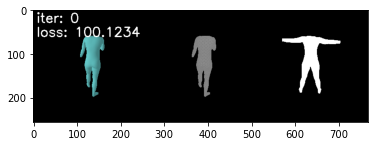

0.7997005 , 0.6541344 , 1.0


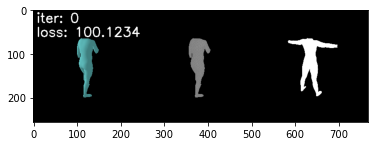

0.79425454 , 0.6729704 , 1.0


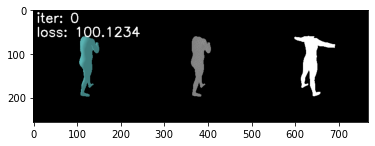

0.75164217 , 0.67391473 , 1.0


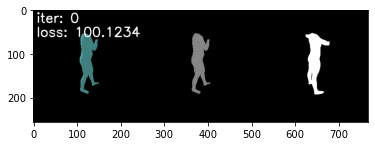

0.7031684 , 0.6446405 , 1.0


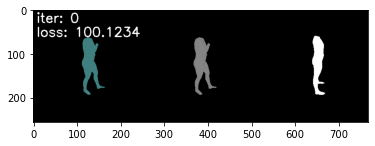

0.6587332 , 0.636453 , 1.0


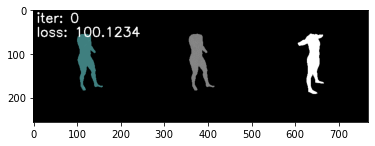

0.74225515 , 0.6334377 , 1.0


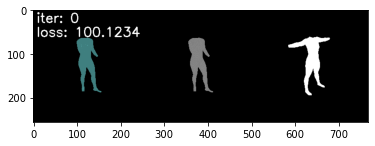

0.77754515 , 0.65321004 , 1.0


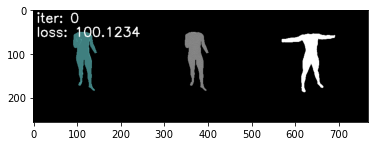

0.86671937 , 0.6994508 , 1.0


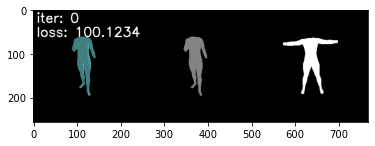

0.86219025 , 0.61386067 , 1.0


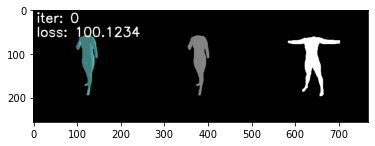

0.8764967 , 0.6252109 , 1.0


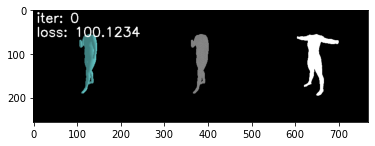

0.8993995 , 0.6318003 , 1.0


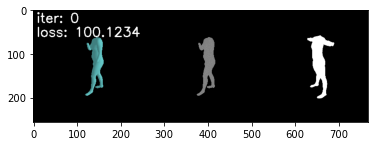

0.8863575 , 0.6337049 , 1.0


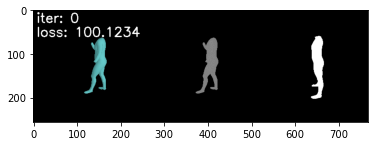

0.89181083 , 0.6953339 , 1.0


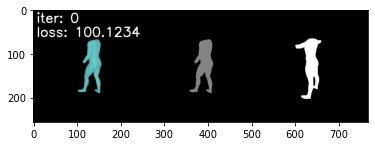

0.89590126 , 0.6584144 , 1.0


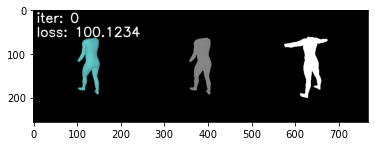

0.8563331 , 0.65694314 , 1.0


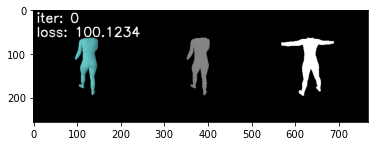

(256, 768, 3)


In [11]:
w_sil = 1
w_normal = 1
w_laplacian = 2
model = Model(meshes=person_mesh.clone(), phong_renderers=phong_renderers, silhouette_renderers=silhouette_renderers, image_refs=image_refs, w_silhoutte=w_sil, w_normal=w_normal, w_laplacian=w_laplacian).to(device)
# model.load_parameters('./3_output/out1/deform_verts3.npy')
# model.load_parameters('./3_output/deform_verts.npy')

loss0, image0_sils, image0_phongs, loss0_sil, loss0_norm, loss0_lap = model(render_phong=True)
print(loss0)
print(loss0.detach().cpu().numpy(), '|', loss0_sil.detach().cpu().numpy(), '|', loss0_norm.detach().cpu().numpy(), '|', loss0_lap.detach().cpu().numpy())

for i in range(len(image0_sils)):
    img_sil = image0_sils[i].detach().cpu().numpy()
    img_pho = image0_phongs[i].detach().cpu().numpy()
    
    img1 = img_pho[0, ..., :3].squeeze()
    img2 = img_sil[...,3].squeeze()
    img_ref = image_refs[i].squeeze().cpu().numpy()
#     render_images3(img2, img1, img_ref)
#     plt.show()
    
    img2 = np.array([img2.T, img2.T, img2.T]).transpose()
    img3 = np.array([img_ref.T, img_ref.T, img_ref.T]).transpose()

    img1 = cv2.flip(img1, -1)
    img2 = cv2.flip(img2, -1)
    img3 = cv2.flip(img3, -1)
    img4 = np.hstack([img1, img2, img3])
    font_scale = 1
    img4 = cv2.putText(img4, 'iter: {}'.format(0), (8, font_scale*20+8), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                       fontScale=1, color=(1, 1, 1), thickness=2, lineType=cv2.LINE_AA) 
    img4 = cv2.putText(img4, 'loss: {:.4f}'.format(100.1234), (8, font_scale*40+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                       fontScale=1, color=(1, 1, 1), thickness=2, lineType=cv2.LINE_AA) 
    print(np.max(img1),',', np.max(img2), ',', np.max(img3))
    plt.figure()
    plt.imshow(img4)
    plt.show()
gif_shape = img4.shape
print(gif_shape)

In [10]:
# precompute initial and target images
img_phos = []
img_refs = []
for i in range(16):
    img_pho = image0_phongs[i].detach().cpu().numpy()
    img_ref = image_refs[i].squeeze().cpu().numpy()
    img1 = img_pho[0, ..., :3].squeeze()
    img3 = np.array([img_ref.T, img_ref.T, img_ref.T]).transpose()
    img1 = cv2.flip(img1, -1)
    img3 = cv2.flip(img3, -1)
    img_phos.append(img1)
    img_refs.append(img3)
out_cam_idx = 0
n_loop = 0
filename_output = '2b_output/temp.gif'
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

losses = {'total_loss': [], 'loss_sil': [], 'loss_normal': [], 'loss_laplacian': []}

In [ ]:
# timestamp
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
filename_output = "./3_output/{}.gif".format(date_str)

loop = tqdm_notebook(range(100000))
lr = 1.0
lr_decay = 0.5
for i in loop:
    mark = i % 100 == 0
    if i > 0 and i % 10000 == 0:
        lr *= lr_decay
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    if mark:
        loss, img_sils, img_phos_curr, l_sil, l_norm, l_lap = model(render_phong=True)
    else:
        loss, _, _, _, _, _ = model(render_phong=False)
    print(loss)
    loop.set_description('[{}/{}] loss {:.6f}'.format(i, len(loop), loss.data))
    loss.backward()
    optimizer.step()
    
    if mark:
        losses['total_loss'].append(loss)
        losses['loss_sil'].append(l_sil)
        losses['loss_normal'].append(l_norm)
        losses['loss_laplacian'].append(l_lap)
        print('Loss: {:.6f}'.format(loss))
        model.save_parameters('./3_output/deform_verts.npy')
        
        if i > 0 and i % 500 == 0:
            model.export_obj('./3_output/obj_{}.obj'.format(i))
        
        img_pho = img_phos_curr[out_cam_idx][0, ..., :3].detach().squeeze().cpu().numpy()
        img2 = cv2.flip(img_pho, -1)
        img1 = img_phos[out_cam_idx]
        img3 = img_refs[out_cam_idx]
        image_out = np.hstack([img1, img2, img3])
        image_out = cv2.resize(image_out, (gif_shape[1]*2, gif_shape[0]*2))
        font_scale = 1
        image_out = cv2.putText(image_out, 'iter: {:<5}| lr: {:.4f}'.format(n_loop, lr), (10, font_scale*20+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                           fontScale=font_scale, color=(1, 1, 1), thickness=2, lineType=cv2.LINE_AA) 
        image_out = cv2.putText(image_out, 'loss: {:.4f}'.format(loss), (10, font_scale*40+24), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                           fontScale=font_scale, color=(1, 1, 1), thickness=2, lineType=cv2.LINE_AA) 
        
        image_out = skimage.img_as_ubyte(image_out)
        writer.append_data(image_out)
        plt.figure()
        plt.imshow(image_out)
#         render_images3(cv2.flip(img1, -1), img_pho, cv2.flip(img3, -1), title1='Initial', title2='{}/{}\nloss={:.4f}'.format(i, len(loop), loss), title3='Target')
        plt.show()
        
        out_cam_idx += 1
        if out_cam_idx == 16:
            out_cam_idx = 0
    n_loop += 1
#     if len(losses['total_loss']) > 2:
#         if abs(losses['total_loss'][-2] - losses['total_loss'][-1]) < 0.01:
#             break
        
writer.close()   

In [ ]:
writer.close()
del writer
# model.save_parameters('./3_output/deform_verts.npy')

In [ ]:
deform_verts = model.deform_verts.detach().cpu().numpy()
print(deform_verts.shape)
out_path = r'./2_output/deform_verts.npy'
np.save(out_path, deform_verts)

# Plot

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(losses['total_loss'], label="Total loss")
ax.plot(losses['loss_sil'], label="Silhouette loss")
ax.plot(losses['loss_normal'], label="Normal loss")
ax.plot(losses['loss_laplacian'], label="Laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration interval", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")
plt.savefig('./3_output/loss.png', dpi=80)

In [ ]:
_, image_final = model()

image_final = image_final.detach().squeeze().cpu().numpy()
render_images(image_init[..., 3], image_final[..., 3])
plt.subplot(1, 2, 1)
plt.imshow(image_init[..., 3])
plt.grid(False)
plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
plt.title("Initial position")

plt.subplot(1, 2, 2)
plt.imshow(image_final[..., 3])
plt.grid(False)
plt.gca().invert_xaxis(), plt.gca().invert_yaxis()
plt.title("Final position")

In [ ]:
loss1, image1_sils, image1_phongs, loss1_sil, loss1_norm, loss1_lap = model(render_phong=True)

output_dir = r'./3_output/final_mesh/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
for i in range(len(image1_sils)):
    img_sil = image1_sils[i].detach().cpu().numpy()
    img_pho = image1_phongs[i].detach().cpu().numpy()
    
    img1 = img_pho[0, ..., :3].squeeze()
    img2 = img_sil[...,3].squeeze()
    img_ref = image_refs[i].squeeze().cpu().numpy()
    render_images3(img2, img1, img_ref)
    plt.suptitle('Camera[{}]'.format(i))
    plt.savefig(output_dir + '{}.png'.format(str(i)), dpi=300)
    plt.close('all')
    img2 = np.array([img2.T, img2.T, img2.T]).transpose()
    img3 = np.array([img_ref.T, img_ref.T, img_ref.T]).transpose()

    img1 = cv2.flip(img1, -1)
    img2 = cv2.flip(img2, -1)
    img3 = cv2.flip(img3, -1)
    img4 = np.hstack([img1, img2, img3])

    print(np.max(img1),',', np.max(img2), ',', np.max(img3))
plt.figure()
plt.imshow(img4)